<a href="https://colab.research.google.com/github/iamviji/project/blob/master/MainModelWithSingleBERTraining.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Note:To Checkin

In [1]:
!rm -rf project
!git clone https://github.com/iamviji/project.git
!ls
!ls project
!pip install pyldpc
!pip install scikit-commpy



Cloning into 'project'...
remote: Enumerating objects: 50, done.
remote: Counting objects: 100% (50/50), done.
remote: Compressing objects: 100% (47/47), done.
remote: Total 50 (delta 10), reused 8 (delta 0), pack-reused 0
Unpacking objects: 100% (50/50), done.
project  sample_data
MainModel.ipynb  README.md  util.py
     |████████████████████████████████| 1.1MB 5.1MB/s 
  Created wheel for pyldpc: filename=pyldpc-0.7.9-cp36-none-any.whl size=14306 sha256=a28f86d2a73432d53766821d694b8cd73b59ba4bd564d9907c2417cce1408271
  Stored in directory: /root/.cache/pip/wheels/47/7a/10/e94058ba8b0b6d98bf2719226d18d3dd6056525ad7b984c068
Successfully built pyldpc
     |████████████████████████████████| 51kB 2.4MB/s 


In [2]:
import pyldpc
import commpy
import numpy 
import time
import tensorflow.compat.v1 as tf
tf.disable_v2_behavior ()

Instructions for updating:
non-resource variables are not supported in the long term


In [3]:
SNR_BEGIN = 0
SNR_END = 10
SNR_STEP_SIZE = 0.5
CHANEL_SIZE = 18
NUM_OF_INPUT_MESSAGE = 1000
LDPC_MAX_ITER = 100
num_parity_check = 3
num_bits_in_parity_check = 6 
input_message_length =  0 # Caculated by channel encoder and initialized later

In [4]:
def timer_update(i,current,time_tot,tic_incr=500):
    last = current
    current = time.time()
    t_diff = current-last
    print('SNR: {:04.3f} - Iter: {} - Last {} iterations took {:03.2f}s'.format(snr,i+1,tic_incr,t_diff))
    return time_tot + t_diff

def Snr2Sigma(snr):
  sigma = 10 ** (- snr / 20)
  return sigma

def pyldpc_encode (CodingMatrix, message):
  rng = pyldpc.utils.check_random_state(seed=None)
  d = pyldpc.utils.binaryproduct(CodingMatrix, message)
  encoded_message = (-1) ** d
  return encoded_message

def pyldpc_decode (ParityCheckMatrix, CodingMatrix, message, snr, maxiter):
  decoded_msg = pyldpc.decode(ParityCheckMatrix, message, snr, maxiter)
  out_message = pyldpc.get_message(CodingMatrix, decoded_msg)
  return out_message

awgn_channel_input = tf.compat.v1.placeholder(tf.float64, [CHANEL_SIZE])
awgn_noise_std_dev = tf.placeholder(tf.float64)
awgn_noise = tf.random.normal(tf.shape(awgn_channel_input), stddev=awgn_noise_std_dev, dtype=tf.dtypes.float64)
awgn_channel_output = tf.add(awgn_channel_input, awgn_noise)

init = tf.global_variables_initializer ()
sess = tf.Session ()
sess.run(init)

def AWGNChannelOutput (xx, snr , s):
  sigma = Snr2Sigma (snr)
  awgn_channel_output_message = s.run ([awgn_channel_output], feed_dict={noise_std_dev:sigma, channel_input:xx})
  return awgn_channel_output_message

In [5]:

ParityCheckMatrix, CodingMatrix = pyldpc.make_ldpc(CHANEL_SIZE, num_parity_check, num_bits_in_parity_check, systematic=True, sparse=True)
input_message_length = CodingMatrix.shape[1]
print ("input_message_size=", input_message_length, "channel_size=",CHANEL_SIZE)
print ("input_message_size=", CodingMatrix.shape[1], "channel_size=",CodingMatrix.shape[0])
input_message = numpy.random.randint(2, size=(NUM_OF_INPUT_MESSAGE,input_message_length))
print (input_message)

input_message_size= 11 channel_size= 18
input_message_size= 11 channel_size= 18
[[1 1 0 ... 1 1 1]
 [0 1 1 ... 1 0 1]
 [0 0 0 ... 1 1 1]
 ...
 [0 0 0 ... 0 1 0]
 [1 1 1 ... 1 1 0]
 [1 1 1 ... 0 0 1]]


This section tries to compare BER and Time performance of PYLDPC in following 3 cases
1. SNR Noise function provided in encoder function of pyldpc library (pyldpc.encode)
2. SNR Noise function provided by commpy library (commpy.channels.awgn) 
3. SNR Noise function implemented using tensorflow 

In [6]:
# Here I am using tensor flow based AWGN, to make sure that effect of it is same as AWGN
output_display_counter = NUM_OF_INPUT_MESSAGE/4
ber_per_iter_tensor  = numpy.array(())
times_per_iter_tensor = numpy.array(())
for snr in numpy.arange (SNR_BEGIN, SNR_END, SNR_STEP_SIZE):
  total_bit_error = 0
  total_msg_error = 0
  total_time = 0
  current_time = time.time()
  for i in range (NUM_OF_INPUT_MESSAGE):
    encoded_message = pyldpc_encode (CodingMatrix, input_message[i])
    sigma = Snr2Sigma (snr)
    awgn_channel_output_message = sess.run ([awgn_channel_output], feed_dict={awgn_noise_std_dev:sigma, awgn_channel_input:encoded_message})[0]
    decoded_message = pyldpc_decode(ParityCheckMatrix, CodingMatrix, awgn_channel_output_message, snr, LDPC_MAX_ITER)
    if abs(decoded_message-input_message[i]).sum() != 0 :
      #print ("count=",abs(decoded_message-input_message[i]).sum())
      total_msg_error = total_msg_error + 1
    if (i+1) % output_display_counter == 0:
      total_time = timer_update(i, current_time,total_time, output_display_counter)
  ber = float(total_msg_error)/NUM_OF_INPUT_MESSAGE
  print('SNR: {:04.3f}:\n -> BER: {:03.2f}\n -> Total Time: {:03.2f}s'.format(snr,ber,total_time))
  ber_per_iter_tensor=numpy.append(ber_per_iter_tensor ,ber)
  times_per_iter_tensor=numpy.append(times_per_iter_tensor, total_time)

/usr/local/lib/python3.6/dist-packages/pyldpc/decoder.py:63: UserWarning: Decoding stopped before convergence. You may want
                       to increase maxiter
  to increase maxiter""")


SNR: 0.000 - Iter: 250 - Last 250.0 iterations took 1.71s
SNR: 0.000 - Iter: 500 - Last 250.0 iterations took 3.12s
SNR: 0.000 - Iter: 750 - Last 250.0 iterations took 4.65s
SNR: 0.000 - Iter: 1000 - Last 250.0 iterations took 6.00s
SNR: 0.000:
 -> BER: 0.60
 -> Total Time: 15.47s
SNR: 0.500 - Iter: 250 - Last 250.0 iterations took 1.29s
SNR: 0.500 - Iter: 500 - Last 250.0 iterations took 2.51s
SNR: 0.500 - Iter: 750 - Last 250.0 iterations took 3.78s
SNR: 0.500 - Iter: 1000 - Last 250.0 iterations took 5.09s
SNR: 0.500:
 -> BER: 0.55
 -> Total Time: 12.67s
SNR: 1.000 - Iter: 250 - Last 250.0 iterations took 1.10s
SNR: 1.000 - Iter: 500 - Last 250.0 iterations took 2.14s
SNR: 1.000 - Iter: 750 - Last 250.0 iterations took 3.07s
SNR: 1.000 - Iter: 1000 - Last 250.0 iterations took 4.07s
SNR: 1.000:
 -> BER: 0.45
 -> Total Time: 10.37s
SNR: 1.500 - Iter: 250 - Last 250.0 iterations took 0.88s
SNR: 1.500 - Iter: 500 - Last 250.0 iterations took 1.93s
SNR: 1.500 - Iter: 750 - Last 250.0 it

In [7]:
# Here I am using commpy based AWGN 
output_display_counter = NUM_OF_INPUT_MESSAGE/4
ber_per_iter_awgn  = numpy.array(())
times_per_iter_awgn = numpy.array(())
for snr in numpy.arange (SNR_BEGIN, SNR_END, SNR_STEP_SIZE):
  total_bit_error = 0
  total_msg_error = 0
  total_time = 0
  current_time = time.time()
  for i in range (NUM_OF_INPUT_MESSAGE):
    encoded_message = pyldpc_encode (CodingMatrix, input_message[i])
    awgn_channel_output_message = commpy.channels.awgn(encoded_message, snr)
    decoded_message = pyldpc_decode(ParityCheckMatrix, CodingMatrix, awgn_channel_output_message, snr, LDPC_MAX_ITER)
    if abs(decoded_message-input_message[i]).sum() != 0 :
      total_msg_error = total_msg_error + 1
    if (i+1) % output_display_counter == 0:
      total_time = timer_update(i, current_time,total_time, output_display_counter)
  ber = float(total_msg_error)/NUM_OF_INPUT_MESSAGE
  print('SNR: {:04.3f}:\n -> BER: {:03.2f}\n -> Total Time: {:03.2f}s'.format(snr,ber,total_time))
  ber_per_iter_awgn=numpy.append(ber_per_iter_awgn ,ber)
  times_per_iter_awgn=numpy.append(times_per_iter_awgn, total_time)

/usr/local/lib/python3.6/dist-packages/pyldpc/decoder.py:63: UserWarning: Decoding stopped before convergence. You may want
                       to increase maxiter
  to increase maxiter""")


SNR: 0.000 - Iter: 250 - Last 250.0 iterations took 1.38s
SNR: 0.000 - Iter: 500 - Last 250.0 iterations took 2.73s
SNR: 0.000 - Iter: 750 - Last 250.0 iterations took 4.12s
SNR: 0.000 - Iter: 1000 - Last 250.0 iterations took 5.40s
SNR: 0.000:
 -> BER: 0.59
 -> Total Time: 13.63s
SNR: 0.500 - Iter: 250 - Last 250.0 iterations took 1.08s
SNR: 0.500 - Iter: 500 - Last 250.0 iterations took 2.34s
SNR: 0.500 - Iter: 750 - Last 250.0 iterations took 3.40s
SNR: 0.500 - Iter: 1000 - Last 250.0 iterations took 4.37s
SNR: 0.500:
 -> BER: 0.53
 -> Total Time: 11.20s
SNR: 1.000 - Iter: 250 - Last 250.0 iterations took 0.99s
SNR: 1.000 - Iter: 500 - Last 250.0 iterations took 1.84s
SNR: 1.000 - Iter: 750 - Last 250.0 iterations took 2.74s
SNR: 1.000 - Iter: 1000 - Last 250.0 iterations took 3.65s
SNR: 1.000:
 -> BER: 0.43
 -> Total Time: 9.21s
SNR: 1.500 - Iter: 250 - Last 250.0 iterations took 0.77s
SNR: 1.500 - Iter: 500 - Last 250.0 iterations took 1.47s
SNR: 1.500 - Iter: 750 - Last 250.0 ite

In [8]:
# Here I am using tensor flow based AWGN, to make sure that effect of it is same as AWGN
output_display_counter = NUM_OF_INPUT_MESSAGE/4
ber_per_iter_pyldpc  = numpy.array(())
times_per_iter_pyldpc = numpy.array(())
for snr in numpy.arange (SNR_BEGIN, SNR_END, SNR_STEP_SIZE):
  total_bit_error = 0
  total_msg_error = 0
  total_time = 0
  current_time = time.time()
  for i in range (NUM_OF_INPUT_MESSAGE):
    encoded_message = pyldpc.encode (CodingMatrix, input_message[i], snr)
    awgn_channel_output_message = encoded_message
    decoded_message = pyldpc_decode(ParityCheckMatrix, CodingMatrix, awgn_channel_output_message, snr, LDPC_MAX_ITER)
    if abs(decoded_message-input_message[i]).sum() != 0 :
      total_msg_error = total_msg_error + 1
    if (i+1) % output_display_counter == 0:
      total_time = timer_update(i, current_time,total_time, output_display_counter)
  ber = float(total_msg_error)/NUM_OF_INPUT_MESSAGE
  print('SNR: {:04.3f}:\n -> BER: {:03.2f}\n -> Total Time: {:03.2f}s'.format(snr,ber,total_time))
  ber_per_iter_pyldpc=numpy.append(ber_per_iter_pyldpc ,ber)
  times_per_iter_pyldpc=numpy.append(times_per_iter_pyldpc, total_time)

/usr/local/lib/python3.6/dist-packages/pyldpc/decoder.py:63: UserWarning: Decoding stopped before convergence. You may want
                       to increase maxiter
  to increase maxiter""")


SNR: 0.000 - Iter: 250 - Last 250.0 iterations took 1.38s
SNR: 0.000 - Iter: 500 - Last 250.0 iterations took 2.70s
SNR: 0.000 - Iter: 750 - Last 250.0 iterations took 3.93s
SNR: 0.000 - Iter: 1000 - Last 250.0 iterations took 5.39s
SNR: 0.000:
 -> BER: 0.61
 -> Total Time: 13.40s
SNR: 0.500 - Iter: 250 - Last 250.0 iterations took 1.14s
SNR: 0.500 - Iter: 500 - Last 250.0 iterations took 2.30s
SNR: 0.500 - Iter: 750 - Last 250.0 iterations took 3.39s
SNR: 0.500 - Iter: 1000 - Last 250.0 iterations took 4.58s
SNR: 0.500:
 -> BER: 0.53
 -> Total Time: 11.41s
SNR: 1.000 - Iter: 250 - Last 250.0 iterations took 1.05s
SNR: 1.000 - Iter: 500 - Last 250.0 iterations took 2.07s
SNR: 1.000 - Iter: 750 - Last 250.0 iterations took 2.98s
SNR: 1.000 - Iter: 1000 - Last 250.0 iterations took 3.97s
SNR: 1.000:
 -> BER: 0.47
 -> Total Time: 10.08s
SNR: 1.500 - Iter: 250 - Last 250.0 iterations took 0.76s
SNR: 1.500 - Iter: 500 - Last 250.0 iterations took 1.57s
SNR: 1.500 - Iter: 750 - Last 250.0 it

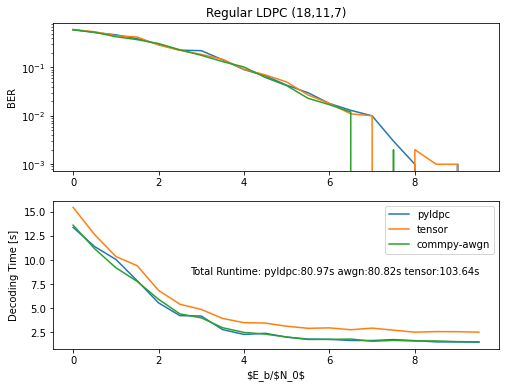

In [9]:
# Compare 3 AWGN(Tensorflow, CommPy, PYLDPC) Simulation on LDPC
import matplotlib.pyplot as plt
%matplotlib inline
snrs = numpy.arange (SNR_BEGIN, SNR_END, SNR_STEP_SIZE)
fig, (ax1,ax2) = plt.subplots(2,1,figsize=(8,6))
ax1.semilogy(snrs,ber_per_iter_pyldpc,'', label="pyldpc") # plot BER vs SNR
ax1.semilogy(snrs,ber_per_iter_tensor,'', label="tensor") # plot BER vs SNR
ax1.semilogy(snrs,ber_per_iter_awgn,'', label="commpy-awgn") # plot BER vs SNR

ax1.set_ylabel('BER')
ax1.set_title('Regular LDPC ({},{},{})'.format(CHANEL_SIZE,input_message_length,CHANEL_SIZE-input_message_length))
ax2.plot(snrs,times_per_iter_pyldpc,'', label="pyldpc") # plot decode timing for different SNRs
ax2.plot(snrs,times_per_iter_tensor,'', label="tensor") # plot decode timing for different SNRs
ax2.plot(snrs,times_per_iter_awgn,'', label="commpy-awgn") # plot decode timing for different SNRs
ax2.set_xlabel('$E_b/$N_0$')
ax2.set_ylabel('Decoding Time [s]')
ax2.annotate('Total Runtime: pyldpc:{:03.2f}s awgn:{:03.2f}s tensor:{:03.2f}s'.format(numpy.sum(times_per_iter_pyldpc), 
            numpy.sum(times_per_iter_awgn), numpy.sum(times_per_iter_tensor)),
            xy=(1, 0.35), xycoords='axes fraction',
            xytext=(-20, 20), textcoords='offset pixels',
            horizontalalignment='right',
            verticalalignment='bottom')
plt.savefig('ldpc_ber_{}_{}.png'.format(CHANEL_SIZE,input_message_length))
plt.legend ()
plt.show()

<B>Conclussion:</B>
      It proved that tensorflow behaves similar to AWGN noise channel provided by pyldpc, commpy. But tensor flow based one takes adds little more time delay. This need to be offseted if we are comparing performance. 

In [17]:
# Define Model 

# input_message_length is initialized by ldpc encoder
num_hidden_1 = CHANEL_SIZE
print ("input_message_length=", input_message_length)

input_message_x = tf.placeholder("float32", [None, input_message_length], name="input_message_x")
awgn_noise_std_dev_x = tf.placeholder("float32", name ="awgn_noise_std_dev")
input_channel_x = tf.placeholder("float32", [None, CHANEL_SIZE], name="input_channel_x")

weights = {
  "encoder_l1" : tf.Variable (tf.random_uniform([input_message_length, num_hidden_1], -1, 1), name="encoder_l1_weights"),
  "decoder_l1" : tf.Variable (tf.random_uniform([num_hidden_1, input_message_length], -1, 1), name="decoder_l1_weights"),
  "decoder_l2" : tf.Variable (tf.random_uniform([input_message_length, input_message_length], -1, 1), name="decoder_l2_weights"),
}

biases = {
  "encoder_l1" : tf.Variable (tf.random_uniform([num_hidden_1], -1,1), name="encoder_l1_bias"),
  "decoder_l1" : tf.Variable (tf.random_uniform([input_message_length], -1,1), name="decoder_l1_bias"),
  "decoder_l2" : tf.Variable (tf.random_uniform([input_message_length], -1,1), name="decoder_l2_bias"),
}

def dl_encoder (x):
  layer_1 = tf.nn.tanh (tf.matmul(x, weights['encoder_l1']) + biases['encoder_l1'])
  #layer_2 = tf.round(layer_1)
  layer_2 =  layer_1 / tf.sqrt(tf.reduce_mean(tf.square(layer_1)))
  #layer_2 =  tf.nn.relu(layer_1)
  return layer_2

def dl_decoder (x):
  layer_1 = tf.nn.tanh (tf.matmul(x, weights['decoder_l1']) + biases['decoder_l1'])
  layer_2 = tf.nn.sigmoid (tf.matmul(layer_1, weights['decoder_l2']) + biases['decoder_l2'])
  return layer_2

def awgn_layer(x):
  awgn_noise = tf.random.normal(tf.shape(x), stddev=awgn_noise_std_dev_x,  name="awgn_noise")
  awgn_channel_output = tf.add(x, awgn_noise, name ="x_and_noise")
  return awgn_channel_output


dl_encoder_output = dl_encoder(input_message_x)
dl_decoder_input = awgn_layer(dl_encoder_output)
#awgn_noise = tf.random.normal(tf.shape(dl_encoder_output), stddev=awgn_noise_std_dev,  name="awgn_noise")
#dl_decoder_input = tf.add(dl_encoder_output, awgn_noise, name ="x_and_noise")
dl_decoder_output = dl_decoder (dl_decoder_input)
dl_decoder_only_output = dl_decoder(input_channel_x)


loss1 = tf.reduce_mean (-1 * (input_message_x*tf.log(dl_decoder_output) + (1 - input_message_x)*tf.log(1 - dl_decoder_output) ))
lr = tf.placeholder(dtype=tf.float32,shape=[])
optimizer1 = tf.train.AdamOptimizer(learning_rate=0.001).minimize (loss1)
optimizer2 = tf.train.AdamOptimizer(learning_rate=0.00001).minimize (loss1)
optimizer3 = tf.train.AdamOptimizer(learning_rate=0.000001).minimize (loss1)

input_message_length= 11


In [19]:
batch_size = 500
training_input_message = numpy.random.randint(2, size=(NUM_OF_INPUT_MESSAGE*10,input_message_length))
print (training_input_message)
print (len(training_input_message))

# Training
train_init = tf.global_variables_initializer ()
train_sess = tf.Session ()

epochs = 900
outer_ephocs = 1
display_step = epochs/4
num_of_batches = len(training_input_message) / batch_size
print ("batch_size:", batch_size, "num_of_batcches:", num_of_batches)
train_sess.run(train_init)
l = 0
lrate = 0.1
i = 0
snr_min = 10
snr_max = 10.5
snr_step_size = 0.5
max_iteration = epochs * num_of_batches * (snr_max - snr_min) / snr_step_size
print ("max iteration :",max_iteration)
for oe in range(outer_ephocs):
  #for snr in (numpy.arange (SNR_BEGIN, SNR_END, SNR_STEP_SIZE)):
  for snr in (numpy.arange (snr_min, snr_max, SNR_STEP_SIZE)):
    sigma = 1.0*Snr2Sigma (snr)
    print ("Training for SNR=", snr, " sigma=", sigma, "iteratin:", oe) 
    for e in range(epochs):
      for j in range (int(num_of_batches)):
        i = i + 1
        x_train_batch = training_input_message [j*batch_size:(j+1)*batch_size]
        x_train_batch_float = x_train_batch.astype("float32")
        if (i < 7000): 
          opt = optimizer1 
          opt_name = "opt1"
        else: 
          opt = optimizer3
          opt_name = "opt3"
        _, l = train_sess.run ([opt, loss1], feed_dict={input_message_x:x_train_batch_float, awgn_noise_std_dev_x:sigma, lr:lrate})
        if i % display_step == 0:          
          print('Step %i: Minibatch Loss: %f opt=%s' % (i, l, opt_name))


[[0 0 1 ... 1 1 0]
 [1 0 1 ... 1 1 1]
 [1 1 1 ... 1 0 1]
 ...
 [1 1 1 ... 0 1 1]
 [0 1 1 ... 1 0 0]
 [0 0 0 ... 0 1 0]]
10000
batch_size: 500 num_of_batcches: 20.0
max iteration : 18000.0
Training for SNR= 10.0  sigma= 0.31622776601683794 iteratin: 0
Step 225: Minibatch Loss: 0.549786 opt=opt1
Step 450: Minibatch Loss: 0.395313 opt=opt1
Step 675: Minibatch Loss: 0.309212 opt=opt1
Step 900: Minibatch Loss: 0.245337 opt=opt1
Step 1125: Minibatch Loss: 0.203189 opt=opt1
Step 1350: Minibatch Loss: 0.176498 opt=opt1
Step 1575: Minibatch Loss: 0.156021 opt=opt1
Step 1800: Minibatch Loss: 0.134053 opt=opt1
Step 2025: Minibatch Loss: 0.117841 opt=opt1
Step 2250: Minibatch Loss: 0.104077 opt=opt1
Step 2475: Minibatch Loss: 0.094802 opt=opt1
Step 2700: Minibatch Loss: 0.079279 opt=opt1
Step 2925: Minibatch Loss: 0.071246 opt=opt1
Step 3150: Minibatch Loss: 0.068211 opt=opt1
Step 3375: Minibatch Loss: 0.061113 opt=opt1
Step 3600: Minibatch Loss: 0.053752 opt=opt1
Step 3825: Minibatch Loss: 0.0505

In [20]:
# Here I am using trained model
output_display_counter = NUM_OF_INPUT_MESSAGE/4
ber_per_iter_dl_tensor  = numpy.array(())
times_per_iter_dl_tensor = numpy.array(())

for snr in numpy.arange (SNR_BEGIN, SNR_END, SNR_STEP_SIZE):
  total_bit_error = 0
  total_msg_error = 0
  total_time = 0
  current_time = time.time()
  sigma = Snr2Sigma (snr)
  for i in range (NUM_OF_INPUT_MESSAGE):
    input_message_xx = input_message [i:i+1]
    input_message_xx_float = input_message_xx.astype("float32")
    encoded_message = train_sess.run ([dl_encoder_output], feed_dict={input_message_x:input_message_xx_float})
    #print (encoded_message[0][0])
    awgn_channel_output_message = sess.run ([awgn_channel_output], feed_dict={awgn_noise_std_dev:sigma, awgn_channel_input:encoded_message[0][0]})
    #print (awgn_channel_output_message)
    decoded_message = train_sess.run ([dl_decoder_only_output], feed_dict={input_channel_x:awgn_channel_output_message})
    #print ("input", input_message[i])
    decoded_message = numpy.around(decoded_message[0][0]).astype(int)
    #print ("output", decoded_message)
    if abs(decoded_message-input_message[i]).sum() != 0 :
      total_msg_error = total_msg_error + 1
    if (i+1) % output_display_counter == 0:
      total_time = timer_update(i, current_time,total_time, output_display_counter)
  ber = float(total_msg_error)/NUM_OF_INPUT_MESSAGE
  print('SNR: {:04.3f}:\n -> BER: {:03.2f}\n -> Total Time: {:03.2f}s'.format(snr,ber,total_time))
  ber_per_iter_dl_tensor=numpy.append(ber_per_iter_dl_tensor ,ber)
  times_per_iter_dl_tensor=numpy.append(times_per_iter_dl_tensor, total_time)

SNR: 0.000 - Iter: 250 - Last 250.0 iterations took 0.30s
SNR: 0.000 - Iter: 500 - Last 250.0 iterations took 0.56s
SNR: 0.000 - Iter: 750 - Last 250.0 iterations took 0.80s
SNR: 0.000 - Iter: 1000 - Last 250.0 iterations took 1.06s
SNR: 0.000:
 -> BER: 0.76
 -> Total Time: 2.71s
SNR: 0.500 - Iter: 250 - Last 250.0 iterations took 0.25s
SNR: 0.500 - Iter: 500 - Last 250.0 iterations took 0.51s
SNR: 0.500 - Iter: 750 - Last 250.0 iterations took 0.76s
SNR: 0.500 - Iter: 1000 - Last 250.0 iterations took 1.04s
SNR: 0.500:
 -> BER: 0.71
 -> Total Time: 2.57s
SNR: 1.000 - Iter: 250 - Last 250.0 iterations took 0.25s
SNR: 1.000 - Iter: 500 - Last 250.0 iterations took 0.50s
SNR: 1.000 - Iter: 750 - Last 250.0 iterations took 0.76s
SNR: 1.000 - Iter: 1000 - Last 250.0 iterations took 1.02s
SNR: 1.000:
 -> BER: 0.67
 -> Total Time: 2.53s
SNR: 1.500 - Iter: 250 - Last 250.0 iterations took 0.25s
SNR: 1.500 - Iter: 500 - Last 250.0 iterations took 0.51s
SNR: 1.500 - Iter: 750 - Last 250.0 itera

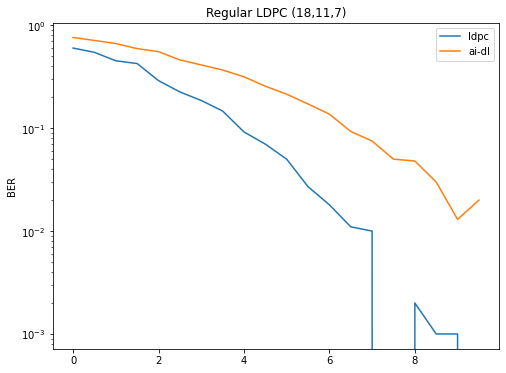

In [21]:
import matplotlib.pyplot as plt
%matplotlib inline
snrs = numpy.arange (SNR_BEGIN, SNR_END, SNR_STEP_SIZE)
fig, (ax1) = plt.subplots(1,1,figsize=(8,6))
ax1.semilogy(snrs,ber_per_iter_tensor,'', label="ldpc") # plot BER vs SNR
ax1.semilogy(snrs,ber_per_iter_dl_tensor,'', label="ai-dl") # plot BER vs SNR
ax1.set_ylabel('BER')
ax1.set_title('Regular LDPC ({},{},{})'.format(CHANEL_SIZE,input_message_length,CHANEL_SIZE-input_message_length))
#ax2.plot(snrs,times_per_iter_pyldpc,'', label="pyldpc") # plot decode timing for different SNRs
#ax2.plot(snrs,times_per_iter_tensor,'', label="tensor") # plot decode timing for different SNRs
#ax2.plot(snrs,times_per_iter_awgn,'', label="commpy-awgn") # plot decode timing for different SNRs
#ax2.set_xlabel('$E_b/$N_0$')
#ax2.set_ylabel('Decoding Time [s]')
#ax2.annotate('Total Runtime: pyldpc:{:03.2f}s awgn:{:03.2f}s tensor:{:03.2f}s'.format(numpy.sum(times_per_iter_pyldpc), 
#            numpy.sum(times_per_iter_awgn), numpy.sum(times_per_iter_tensor)),
#            xy=(1, 0.35), xycoords='axes fraction',
#            xytext=(-20, 20), textcoords='offset pixels',
#            horizontalalignment='right',
#            verticalalignment='bottom')
plt.savefig('ldpc_ber_{}_{}.png'.format(CHANEL_SIZE,input_message_length))
plt.legend ()
plt.show()